In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import datetime
import os
import shutil

## V1: Using the full action space
## V2: Simplified model
#from SimioEnv_v2 import SimioPickDontMoveEnv
from SimioEnv_v2p1 import SimioPickDontMoveEnv
from FunctionApproximators_v2p2 import PolicyEstimator, ValueEstimator

from IPython.core.debugger import set_trace
from gym_helpers import flatten_space_sample

if "../" not in sys.path:
  sys.path.append("../") 
#from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
# env = gym.make('FrozenLake8x8-v0') # FrozenLake8x8-v0 FrozenLake-v0
# env = SimioFrozenLakeEnv(num_states=64, num_actions=4, log_output=False)
env = SimioPickDontMoveEnv(
    num_locations=8, 
    num_pickers=1, 
    num_agvs=2,
    log_output=False, 
    log_end_episode_only=False
    )

print("Num Pickers: ", env.num_pickers)
print("Num AGVs: ", env.num_agvs)
print("Num Warehouse Locations: ", env.num_locations)

print()
print("Action Space:")
print("=============")
print(env.action_space)
print()
print("Observation Space:")
print("==================")
print(env.observation_space)

Num Pickers:  1
Num AGVs:  2
Num Warehouse Locations:  8

Action Space:
MultiDiscrete([3 8 8])

Observation Space:
MultiDiscrete([11 11 11 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20])


In [3]:
# example = {
#     'Status':  0.0 , 
#     'EpisodeNum':  1.0 , 
#     'Reward':  2.0 , 
#     'States':  {
#         'PickerCurrentAction': 3.0, 
#         'PickerLocation': 4.0, 
#         'AGV1CurrentAction': 5.0, 
#         'AGV1Location': 6.0, 
#         'AGV1RemainingOrderQuantities': [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0], 
#         'AGV2CurrentAction': 15.0, 
#         'AGV2Location': 16.0, 
#         'AGV2RemainingOrderQuantities': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0], 
#         'Order1Quantities': [], 
#         'Order2Quantities': [], 
#         'Order3Quantities': [], 
#         'Order4Quantities': [], 
#         'Order5Quantities': []
#     }
# }
# example_state = example['States']
# 
# env.flatten_state(example_state)

In [4]:
# flatten_space_sample(env.observation_space.sample())

# def flatten_space_sample2(sample):
#     return np.array(flatten_space_sample(sample)).reshape(-1, 1).T

In [5]:
# Reshapes a list of integers into a format tensorflow can understand
def reshape_state(state):
    return np.array(state).reshape(-1, 1).T

In [6]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        state = env.reset()
        state = reshape_state(state)
        
        
        watchdog_start = datetime.datetime.now()
        
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            # action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = [np.random.choice(np.arange(len(prob)), p=prob) for prob in action_probs] # action for each picker, agv
                
            next_state, reward, done, _ = env.step(action)
            next_state = reshape_state(next_state)
            
            
            # Keep track of the transition
            episode.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done))
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            # rint("\rStep {} @ Episode {}/{} ({})".format(
            #        t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()
            
            print("\r\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t", end="")
            print("\r[step {}][ep {}/{}] cumulative_reward={:.2f}".format(
                 t,
                 i_episode+1,
                 num_episodes,
                 stats.episode_rewards[i_episode]), end="")
            
            
            if done:
                break
                
            state = next_state
            
            watchdog_end = datetime.datetime.now()
            if ((watchdog_end-watchdog_start).total_seconds() > 10):
                env.finalize()
                return stats
            watchdog_start = watchdog_end
            
            if os.path.exists('terminate.txt'):
                return stats
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
        env.finalize()
        
    return stats

In [7]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    stats = plotting.EpisodeStats(episode_lengths=np.zeros(num_episodes), episode_rewards=np.zeros(num_episodes)) # Keeps track of useful statistics
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        state = reshape_state(state)
        
        episode = []
        
        
        watchdog_start = datetime.datetime.now()
        
        
        # One step in the environment
        for t in itertools.count():
            
            action_probs = estimator_policy.predict(state)
            # action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            
            #TF1
            actions = [np.random.choice(np.arange(len(prob)), p=prob) for prob in action_probs] # action for each picker, agv
            
            
            #TF2
            # action_probs_flattened = [x.flatten() for x in action_probs]
            # actions = [np.random.choice(np.arange(len(prob)), p=prob) for prob in action_probs_flattened]
            
            next_state, reward, done, _ = env.step(actions) 
            next_state = reshape_state(next_state)
            
            
            # Keep track of the transition, update statistics
            episode.append(Transition(state=state, action=actions, reward=reward, next_state=next_state, done=done))
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # TF1
            # # Update the value estimator
            value_loss = estimator_value.update(state, td_target)
            # # Update the policy estimator
            # # using the td error as our advantage estimate
            policy_loss = estimator_policy.update(state, td_error, actions)
            
            
            # print("\r[step {}][ep {}/{}] Vn={} TD={} TDE={} r={} Vloss={} Ploss={}".format(
            #      t,
            #      i_episode+1,
            #      num_episodes,
            #      
            #      value_next,
            #      td_target,
            #      td_error,
            #      reward,
            #      value_loss,
            #      policy_loss), end="")
            # print("\r\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t", end="")
            print("\r[step {}][ep {}/{}] cumulative_reward={:.2f} Vloss={} Ploss={}\t\t\t".format(
                 t,
                 i_episode+1,
                 num_episodes,
                 stats.episode_rewards[i_episode],
                 value_loss,
                 policy_loss), end="")
            
            # probs_string = ["{:.2f}".format(x) for x in action_probs[1]]
            # print("\r[step {}][ep {}/{}] action_probs={}".format(
            #     t, 
            #     i_episode+1, 
            #     num_episodes, 
            #     probs_string), end="")
            
            # if td_error > 0.001 or td_error < -0.001:
            #     variables = tf.trainable_variables()
            #     variables_vals = sess.run(variables)
            #     varlist = []
            #     for var, val in zip(variables, variables_vals):
            #         print("var: {}, value: {}".format(var.name, val))
            
            # Print out which step we're on, useful for debugging.
            # print("\rStep {} @ Episode {}/{} ({})\t\t\t\t\t".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # if td_target > 0.0001 or td_target < -0.0001:
            #     print("============================")
            #     print("Step {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]))
            #     print("td target", td_target, "td error", td_error)
            #     print("value loss", value_loss, "policy loss", policy_loss)
            #     print("============================")
            # print("\rStep {} @ Episode {}/{} ({})\t\t\t\t\t".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            if done:
                break
                
            state = next_state
            
            watchdog_end = datetime.datetime.now()
            if ((watchdog_end-watchdog_start).total_seconds() > 10):
                return stats
            watchdog_start = watchdog_end
            
        env.finalize()
        
    return stats

In [8]:
NUM_EPISODES = 300000
DISCOUNT_FACTOR = 1.0
LEARNING_RATE = 0.00001
ALGORITHM = "reinforce" # actor_critic or reinforce

In [9]:
## TF1:
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(env, learning_rate=LEARNING_RATE) #0.00001
value_estimator = ValueEstimator(env, learning_rate=LEARNING_RATE) #0.00001

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use tf.cast instead.


In [10]:
# #%load_ext tensorboard.notebook
# %reload_ext tensorboard.notebook
# logs_path = "./tensorboard_actorcriticsimio111"
# summary_writer = tf.summary.FileWriter(logdir=logs_path, graph=tf.get_default_graph()) # , graph=g
# %tensorboard --logdir tensorboard_actorcriticsimio111/

In [11]:


## TF1
#policytable = []
#valuetable = []
start_training = datetime.datetime.now()
print("#######################################")
print("started run:", start_training)
print("#######################################")
print()
with tf.Session() as sess:
    # sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    
    if ALGORITHM == "actor_critic":
        stats = actor_critic(env, policy_estimator, value_estimator, num_episodes=NUM_EPISODES, discount_factor=DISCOUNT_FACTOR)
    elif ALGORITHM == "reinforce":
        stats = reinforce(env, policy_estimator, value_estimator, num_episodes=NUM_EPISODES, discount_factor=DISCOUNT_FACTOR)

    # Output the final policy and value tables
    #for i in range(env.observation_space.n):
    #    policytable.append(policy_estimator.predict(i))
    #    valuetable.append(value_estimator.predict(i))
    variables = tf.trainable_variables()
    variables_vals = sess.run(variables)
    # print(variables) #some infos about variables...
    varlist = []
    for var, val in zip(variables, variables_vals):
        varlist.append({var.name: val})
        # print("var: {}, value: {}".format(var.name, val)) #...or sort it in a list....
    # print varlist
end_training = datetime.datetime.now()


#######################################
started run: 2020-02-15 12:44:06.383509
#######################################

[step 405][ep 300000/300000] cumulative_reward=-10.09

######################################
algorithm: reinforce
num eps: 300000
discount: 1.0
learning rate: 1e-05
started run: 2020-02-15 12:44:06.383509
ended run: 2020-02-18 07:08:02.023577
duration: 239035.640068
max reward: 4.845499998773448 @ episode: 147008
min reward: -15.792650008748751 @ episode: 291284
######################################


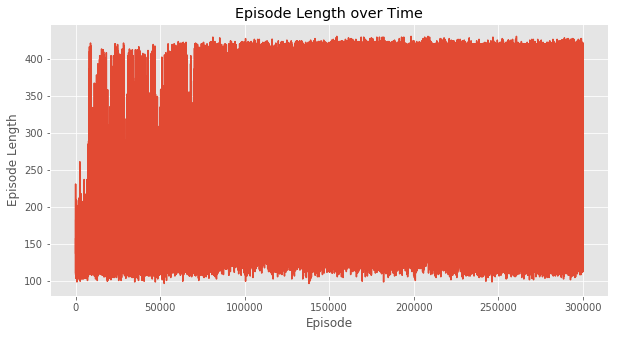

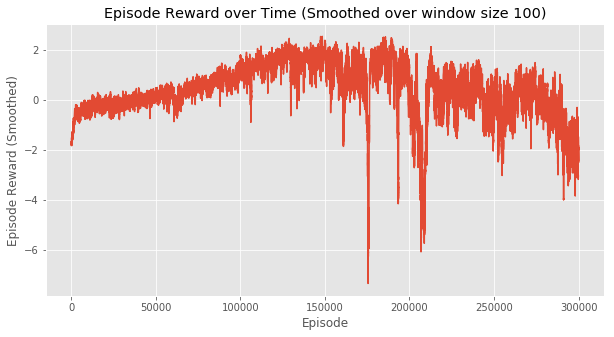

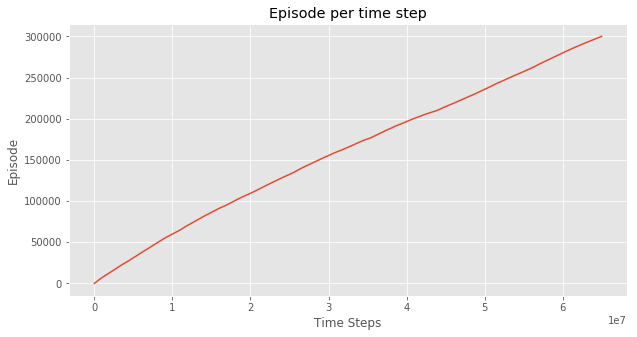

In [17]:
destination_folder = "training_logs/{}".format(end_training.strftime("%Y-%m-%d %H.%M"))
os.makedirs(destination_folder, exist_ok=True)
file = open('{}/summary.txt'.format(destination_folder), 'w')

for f in [file, None]:
    print("######################################", file=f)
    print("algorithm:", ALGORITHM, file=f)
    print("num eps:", NUM_EPISODES, file=f)
    print("discount:", DISCOUNT_FACTOR, file=f)
    print("learning rate:", LEARNING_RATE, file=f)
    print("started run:", start_training, file=f)
    print("ended run:", end_training, file=f)
    print("duration:", (end_training - start_training).total_seconds(), file=f)
    print("max reward:", stats.episode_rewards.max(), "@ episode:", stats.episode_rewards.argmax(), file=f)
    print("min reward:", stats.episode_rewards.min(), "@ episode:", stats.episode_rewards.argmin(), file=f)
    print("######################################", file=f)
file.close()

figures = plotting.plot_episode_stats(stats, smoothing_window=100)

for figure in figures:
    figure.savefig('{}/{}.png'.format(destination_folder, figure.gca().get_title()))

In [13]:
## TF2
# tf.keras.backend.clear_session()  # For easy reset of notebook state.
# print("#######################################")
# print("started run:", datetime.datetime.now())
# print("#######################################")
# stats = actor_critic(env, policy_estimator, value_estimator, num_episodes=200, discount_factor=1.0)
# print("######################################")
# print("ended run:", datetime.datetime.now())
# print("######################################")